Pixel Tests

In [137]:
import glob
import numpy as np
import tensorflow.keras as tk
from PIL import Image
import pandas as pd
import seaborn as sns


In [138]:

countyList = ['Arkansas_005', 'Arkansas_019','Arkansas_020', 'Arkansas_080', 'Arkansas_173',
'Clay_010', 'Clay_016','Clay_017','Clay_062', 'Clay_076',
'Craighead_014', 'Craighead_020','Craighead_026','Craighead_041','Craighead_055',
'Crittenden_015', 'Crittenden_024','Crittenden_034','Crittenden_054','Crittenden_056',
'Desha_043', 'Desha_044','Desha_058','Desha_059','Desha_087','Desha_043',     
'Greene_028','Greene_037','Greene_038','Greene_043','Greene_049',
"Jackson_033", "Jackson_044","Jackson_107","Jackson_116","Jackson_139",
'Jefferson_008', 'Jefferson_009','Jefferson_027','Jefferson_077','Jefferson_127',    
'Lawrence_050', 'Lawrence_075','Lawrence_093','Lawrence_097','Lawrence_098',
'Mississippi_027', 'Mississippi_032','Mississippi_059','Mississippi_084','Mississippi_096',    
'Woodruff_024','Woodruff_037','Woodruff_069','Woodruff_078','Woodruff_099']


In [139]:
model = tk.models.load_model('FinalModel.h5')

In [140]:
from sklearn.metrics import confusion_matrix
def ber(label, logit):
      mat= confusion_matrix(label, logit)
      if len(mat) == 1:
        return -1
      TN, FP, FN, TP = mat.ravel()
      W = len(label)
      NP = sum(label)
      NN = W ** 2 - NP
      BER = (1 - .5 * (TP / NP + TN / NN))

      if TP == 0:
        if NP == 1.0:
          BER = 0
        else:
          BER = None
      
      return BER

In [141]:
threshold = 0.7

In [142]:
def thresholdRavel(array):
  newArr = np.copy(array)
  row = newArr.shape
  row = row[0]
  for i in range(row):
    if newArr[i] < threshold:
      newArr[i] = 0
    else:
      newArr[i] = 1
  return newArr

In [143]:
def thresholdArray(array):
  newArr = np.copy(array).ravel()
  row = len(newArr)
  for i in range(row):
      if newArr[i] < threshold:
        newArr[i] = 0
      else:
        newArr[i] = 1
  return newArr

In [144]:
ACC_dict = {}
BER_dict = {}
IOU_dict = {}
F1_dict  = {}

In [145]:
predList = sorted(glob.glob("/Volumes/Research/CropContour/ConvertedPredictions/AR_Arkansas" + "*.tif"))
print(predList[0])

labelList =  sorted(glob.glob("/Volumes/Research/CropContour/55tiles/label/AR_Arkansas" + "*.tif"))
print(labelList[0])

/Volumes/Research/CropContour/ConvertedPredictions/AR_Arkansas_005_pred_0_0.tif
/Volumes/Research/CropContour/55tiles/label/AR_Arkansas_005_Mask_Mask_0_0.tif


In [146]:
acc_ex = []
f1_ex =[]
iou_ex =[]
B_ex = []
Y_test_ex = []
Y_pred_ex = []
num_pos_test_ex = []
for county in countyList:
    predList = sorted(glob.glob("/Volumes/Research/CropContour/ConvertedPredictions/AR_" + county + "*.tif"))
    labelList =  sorted(glob.glob("/Volumes/Research/CropContour/55tiles/label/AR_" + county + "*.tif"))
    for i in range(len(predList)):
        #print(predList[i], " and ", labelList[i])
        img = Image.open(predList[i])
        Y_pred = np.asarray(img)
        Y_pred = np.reshape(Y_pred,(320,320,1))

        img = Image.open(labelList[i])
        Y_test = np.asarray(img)
        Y_test = Y_test[::3,::3]
        num_pos_test_ex.append(sum(Y_test.ravel()))
        Y_test = np.reshape(Y_test,(320,320,1))
        Y_test = np.asarray(Y_test)
    
        row, col, _ = Y_test.shape
        if sum(Y_test.ravel())  >= (row*col*(3.0/10)):
            Y_test_ex.append(Y_test[i])
            Y_pred_ex.append(Y_pred[i])
            from sklearn.metrics import accuracy_score
            acc_ex.append(accuracy_score(Y_test.ravel(),thresholdRavel(Y_pred.ravel())))
            #print(ACC_dict[county])

            #print("Diff F1")
            from sklearn.metrics import f1_score
            f1_ex.append(f1_score(Y_test.ravel(),thresholdRavel(Y_pred.ravel())))

            #print("Diff IOU")
            from sklearn.metrics import jaccard_score
            iou_ex.append(jaccard_score(Y_test.ravel(),thresholdRavel(Y_pred.ravel())))

            #print("Diff BER")
            BER = ber(Y_test[:,:,0].ravel(),thresholdArray(Y_pred[:,:,0]).ravel())
            B_ex.append(BER)


In [147]:
print(len(Y_test_ex))
print(len(Y_pred_ex))

258
258


In [148]:
Y_test_ex = np.array(Y_test_ex)
Y_pred_ex = np.array(Y_pred_ex)

In [149]:
import statistics
from sklearn.metrics import precision_score, recall_score
print("Overall 55 tiles Performance for >30%")
print(" Accuracy: ", accuracy_score(Y_test_ex.ravel(),thresholdRavel(Y_pred_ex.ravel())))
print(" F1: ", f1_score(Y_test_ex.ravel(),thresholdRavel(Y_pred_ex.ravel())))
print("     Precision: ", precision_score(Y_test_ex.ravel(),thresholdRavel(Y_pred_ex.ravel())))
print("     Recall: ", recall_score(Y_test_ex.ravel(),thresholdRavel(Y_pred_ex.ravel())))
print(" IOU: ",jaccard_score(Y_test_ex.ravel(),thresholdRavel(Y_pred_ex.ravel())))
print(" BER: ",ber(Y_test_ex.ravel(),thresholdArray(Y_pred_ex).ravel()))
print(" STDEV:", statistics.stdev(num_pos_test_ex))
print(" Avg Pixel:", sum(num_pos_test_ex)/len(num_pos_test_ex))

Overall 55 tiles Performance for >30%
 Accuracy:  0.7715358527131783
 F1:  0.6819653335131854
     Precision:  0.9029334285841853
     Recall:  0.5478854542006448
 IOU:  0.517410771395676
 BER:  0.7260540837670686
 STDEV: 21264.30538838178
 Avg Pixel: 14338.128571428571


In [150]:
acc_in = []
f1_in =[]
iou_in =[]
B_in = []
Y_test_in = []
Y_pred_in = []
X_test_in = []
num_pos_test_in = []
for county in countyList:
    predList = sorted(glob.glob("/Volumes/Research/CropContour/ConvertedPredictions/AR_" + county + "*.tif"))
    labelList =  sorted(glob.glob("/Volumes/Research/CropContour/55tiles/label/AR_" + county + "*.tif"))
    imgList = sorted(glob.glob("/Volumes/Research/CropContour/Code/55TilesTest/test/img/AR_" + county + "*.tif"))

    for i in range(len(predList)):
        #print(predList[i], " and ", labelList[i])
        img = Image.open(predList[i])
        Y_pred = np.asarray(img)
        Y_pred = np.reshape(Y_pred,(320,320,1))
        Y_pred_in.append(Y_pred)

        img = Image.open(labelList[i])
        Y_test = np.asarray(img)
        Y_test = Y_test[::3,::3]
        Y_test = np.reshape(Y_test,(320,320,1))
        num_pos_test_in.append(sum(Y_test.ravel()))
        Y_test = np.asarray(Y_test)
        Y_test_in.append(Y_test)

        img = Image.open(imgList[i])
        X_test = np.asarray(img)
        X_test = X_test[::3,::3]
        X_test = np.reshape(X_test,(320,320,1)) 
        X_test = np.asarray(X_test)
        X_test_in.append(X_test)
 
       
        from sklearn.metrics import accuracy_score
        acc_in.append(accuracy_score(Y_test.ravel(),thresholdRavel(Y_pred.ravel())))
        #print(ACC_dict[county])

        #print("Diff F1")
        from sklearn.metrics import f1_score
        f1_in.append(f1_score(Y_test.ravel(),thresholdRavel(Y_pred.ravel())))

        #print("Diff IOU")
        from sklearn.metrics import jaccard_score
        iou_in.append(jaccard_score(Y_test.ravel(),thresholdRavel(Y_pred.ravel())))

        #print("Diff BER")
        BER = ber(Y_test[:,:,0].ravel(),thresholdArray(Y_pred[:,:,0]).ravel())
        B_in.append(BER)

/Users/dakota/opt/anaconda3/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/dakota/opt/anaconda3/envs/ML/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/dakota/opt/anaconda3/envs/ML/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dakota/opt/anaconda3/envs/ML/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-define

In [151]:
# import statistics as stats
# print("Average: ", sum(B_in)/len(B_in))
# print("Standard Dev: ",stats.stdev(B_in))
# print("Max: ", max(B_in))
# print("Min: ", min(B_in))

In [152]:
Y_test_in = np.array(Y_test_in)
Y_pred_in = np.array(Y_pred_in)
X_test_in = np.array(X_test_in)

In [153]:
numSamples = X_test_in.shape[0]
sampleDF = pd.DataFrame(columns=['Acc', "F1", "IOU", "BER"])
print(len(B_in))

for i in range(numSamples):
    sampleDF = sampleDF.append({"Acc": acc_in[i],"F1": f1_in[i],"IOU": iou_in[i],"BER": B_in[i] },ignore_index=True)


1400


In [154]:
sampleDF = sampleDF.sort_values("F1")
print(sampleDF[sampleDF['F1'] != 0.0].head())

           Acc        F1       IOU       BER
1119  0.699131  0.000065  0.000032  0.999963
235   0.699541  0.000065  0.000033  0.999980
733   0.406670  0.000066  0.000033  0.999977
937   0.417168  0.000134  0.000067  0.998995
741   0.905039  0.000206  0.000103  0.999942


In [155]:
sampleDF = sampleDF[sampleDF['F1'] != 0.0]
indx = sampleDF.index[:4]

print(indx)

Int64Index([1119, 235, 733, 937], dtype='int64')


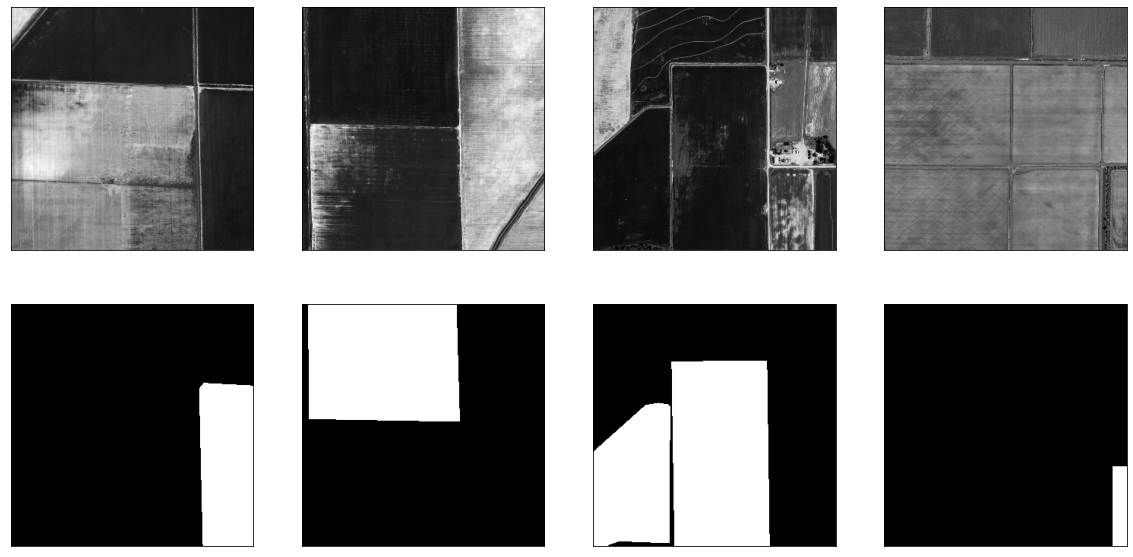

In [156]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(2,4, figsize=(20,10))
ax[0,0].imshow(X_test_in[indx[0],:,:,0],cmap='gray')
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[1,0].imshow(Y_test_in[indx[0],:,:,0],cmap='gray')
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])

ax[0,1].imshow(X_test_in[indx[1],:,:,0],cmap='gray')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[1,1].imshow(Y_test_in[indx[1],:,:,0],cmap='gray')
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])

ax[0,2].imshow(X_test_in[indx[2],:,:,0],cmap='gray')
ax[0,2].set_xticks([])
ax[0,2].set_yticks([])
ax[1,2].imshow(Y_test_in[indx[2],:,:,0],cmap='gray')
ax[1,2].set_xticks([])
ax[1,2].set_yticks([])

ax[0,3].imshow(X_test_in[indx[3],:,:,0],cmap='gray')
ax[0,3].set_xticks([])
ax[0,3].set_yticks([])
ax[1,3].imshow(Y_test_in[indx[3],:,:,0],cmap='gray')
ax[1,3].set_xticks([])
ax[1,3].set_yticks([])
plt.savefig("Worst55tile.png", dpi=300)
plt.show()

In [ ]:
import statistics
print("Overall 55 tiles Performance for All tiles")
print(" Accuracy: ", accuracy_score(Y_test_in.ravel(),thresholdRavel(Y_pred_in.ravel())))
print(" F1: ", f1_score(Y_test_in.ravel(),thresholdRavel(Y_pred_in.ravel())))
print("     Precision: ", precision_score(Y_test_in.ravel(),thresholdRavel(Y_pred_in.ravel())))
print("     Recall: ", recall_score(Y_test_in.ravel(),thresholdRavel(Y_pred_in.ravel())))
print(" IOU: ",jaccard_score(Y_test_in.ravel(),thresholdRavel(Y_pred_in.ravel())))
print(" BER: ",ber(Y_test_in.ravel(),thresholdArray(Y_pred_in).ravel()))
print(" STDEV:", statistics.stdev(num_pos_test_in))
print(" Avg Pixel:", sum(num_pos_test_in)/len(num_pos_test_in))

Overall 55 tiles Performance for All tiles


In [ ]:
Y_test_noVoid = []
Y_pred_noVoid = []
shp = Y_test_in.shape

for i in range(shp[0]):
    if sum(Y_test_in[i].ravel()) != 0:
        Y_test_noVoid.append(Y_test_in[i])
        Y_pred_noVoid.append(Y_pred_in[i])

In [ ]:
Y_test_noVoid = np.array(Y_test_noVoid)
Y_pred_noVoid = np.array(Y_pred_noVoid)

In [ ]:
print("Overall 55 tiles Performance for All tiles with Labels")
print(" Accuracy: ", accuracy_score(Y_test_noVoid.ravel(),thresholdRavel(Y_pred_noVoid.ravel())))
print(" F1: ", f1_score(Y_test_noVoid.ravel(),thresholdRavel(Y_pred_noVoid.ravel())))
print(" IOU: ",jaccard_score(Y_test_noVoid.ravel(),thresholdRavel(Y_pred_noVoid.ravel())))
print(" BER: ",ber(Y_test_noVoid.ravel(),thresholdArray(Y_pred_noVoid).ravel()))

In [ ]:
print(min(f1_in))

In [ ]:
#Exclusive
num_samples = len(acc_ex)
print("Number Exclusive:", num_samples)
print("Num BER", len(B_ex))
metrics = pd.DataFrame(columns=["Metric", "Value", "Ex/In"])
for i in range(num_samples):
    metrics = metrics.append({"Metric": "Accuracy" , "Value": acc_ex[i], "Ex/In": ">30%" },ignore_index=True)
    metrics = metrics.append({"Metric": "F1" , "Value": f1_ex[i], "Ex/In": ">30%"  },ignore_index=True)
    metrics = metrics.append({"Metric": "IOU", "Value": iou_ex[i], "Ex/In": ">30%"  },ignore_index=True)
for i in B_ex:
    if i is not None:
        metrics = metrics.append({"Metric": "BER" , "Value": i, "Ex/In": ">30%"},ignore_index=True)


In [ ]:
#In
num_samples = len(acc_in)
print("Number Inclusive:", num_samples)
print("Num BER", len(B_in))

for i in range(num_samples):
    metrics = metrics.append({"Metric": "Accuracy" , "Value": acc_in[i], "Ex/In": "all" },ignore_index=True)
    metrics = metrics.append({"Metric": "F1" , "Value": f1_in[i], "Ex/In": "all" },ignore_index=True)
    metrics = metrics.append({"Metric": "IOU", "Value": iou_in[i], "Ex/In": "all"  },ignore_index=True)
for i in B_in: 
    if i is not None:
        metrics = metrics.append({"Metric": "BER" , "Value": i, "Ex/In": "all"},ignore_index=True)

In [ ]:
metrics.head()

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14, 'font.family' : "serif"})
ax = sns.violinplot(x="Metric",y="Value", hue="Ex/In",
                    data=metrics, palette="colorblind", cut=0, legend=False,inner="box")
plt.legend([],[], frameon=False)
plt.yticks([])
plt.savefig('Graphs/splitViolin_55tiles.png',dpi=300)

In [ ]:
from scipy import ndimage
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import block_reduce
import os
import json
from glob import glob
import tensorflow.keras as tk


MEAN_B = 103.939 
MEAN_G = 116.779
MEAN_R = 123.68
GenerateSpecificMask = True
dict_color = {
    'u': 'white',
    'c': 'red',
    's': 'green',
    'p': 'blue',
    'z': 'yellow',
}
dict_code = {
    'u': 1,
    'c': 2,
    's': 3,
    'p': 4,
    'z': 5,
}

numContour = 0
numStraight = 0
numPivot = 0
numZero = 0
numUnknown = 0

SpecificMask = 2
Grayscale = True #@param {type:"boolean"}

def gray(filename):
    
    import numpy as np
    import matplotlib.pyplot as pyplot

    img = Image.open(filename)

    img.getdata()
    #print(img.split())
    tup = img.split()
    if len(tup) == 3:
      r, g, b = tup
    else:
      return

    ra = np.array(r)
    ga = np.array(g)
    ba = np.array(b)

    gray = (0.299*ra + 0.587*ga + 0.114*ba)

    img = Image.fromarray(gray)
    img.save(filename)

def spatial_subset_image(srcImgfile,outsize,dstPath,startX=0,startY=0,sBand=0):
    '''Get spatial subset of a image by
    a moving window.

    :param infile: image file in geotiff format.
    :param outpath: image file in geotiff format.
    :param size: subset size of image
    :return: true if it sucess, otherwise false
    '''
    try:
        src_ds = gdal.Open(srcImgfile)
    except RuntimeError as e:
        print("Unable to open %s",srcImgfile)
        return False
    cols = src_ds.RasterXSize
    rows = src_ds.RasterYSize
    proj_ds = src_ds.GetProjectionRef()
    trans_ds = src_ds.GetGeoTransform()
    datatype = src_ds.GetRasterBand(1).DataType

    if outsize > cols or outsize > rows:
        print("The  size of output image is larger than the inpot image.")
        print(outsize)
        print(cols)
        print(rows)
        return False

    n_img_cols = int((cols - cols%outsize)/outsize)
    n_img_rows = int((rows - rows%outsize)/outsize)
    cols_begin = int((cols%outsize)/2)
    rows_begin = int((rows%outsize)/2)

    img = np.array(src_ds.ReadAsArray())
    n_dims = len(img.shape)

    for i_col in range(n_img_cols):
        cols_head = cols_begin + i_col*outsize
        for i_row in range(n_img_rows):
            row_head = rows_begin + i_row*outsize
            dst_name = dstPath +"_"+str(i_col) + "_" + str(i_row) +".tif"
            x_min = trans_ds[0] + trans_ds[1]*cols_head
            y_max =  trans_ds[3] +  trans_ds[5]*row_head
            if n_dims > 2 and sBand ==0:
                out_array = img[0:3,row_head:(row_head+outsize),cols_head:(cols_head+outsize)]
                #out_array = out_array.transpose(1,2,0)
                #io.imsave(dst_name,out_array)

                _array_to_raster(img[:,row_head:(row_head+outsize),cols_head:(cols_head+outsize)], 
                                 dst_name, outsize, outsize, trans_ds[1], trans_ds[5], 
                                 x_min, y_max, proj_ds,datatype)
            elif n_dims > 2 and sBand ==1:
                out_array = img[0,row_head:(row_head+outsize),cols_head:(cols_head+outsize)]
                #out_array = out_array.transpose(1,2,0)
                #io.imsave(dst_name,out_array)

                _array_to_raster(
                    img[0,row_head:(row_head+outsize),cols_head:(cols_head+outsize)], 
                    dst_name, outsize, outsize, trans_ds[1], trans_ds[5], 
                    x_min, y_max, proj_ds,datatype
                )
            else:
                #io.imsave(dst_name,img[row_head:(row_head+outsize),cols_head:(cols_head+outsize)])
                _array_to_raster(
                    img[row_head:(row_head+outsize),cols_head:(cols_head+outsize)], 
                    dst_name, outsize, outsize, trans_ds[1], trans_ds[5], 
                    x_min, y_max, proj_ds,datatype
                )

    src_ds = None
    return True
def _array_to_raster(array,dst_filename,x_size,y_size,x_pixels,y_pixels,x_min,y_max,wkt_projection,datatype):
    """Array > Raster
    Save a raster from a C order array.

    :param array: ndarray
    :dst_filename: filename
   """

    geotransform = (x_min, x_pixels, 0, y_max, 0, y_pixels)
    dims = min(array.shape)


    if len(array.shape) == 2:
        n_bands = 1
    if len(array.shape) > 2 and dims >0 and dims < 32:
        n_bands = 3


    # create the n-band raster file
    dst_ds = gdal.GetDriverByName('GTiff').Create(dst_filename, x_size, y_size, n_bands, datatype)

    dst_ds.SetGeoTransform(geotransform)  # specify coords
    dst_ds.SetProjection(wkt_projection)  # export coords to file
    if n_bands > 1:
        for i in range(n_bands):
            dst_ds.GetRasterBand(i+1).WriteArray(array[i,:,:])  # write a band to the raster
    if n_bands == 1:
        dst_ds.GetRasterBand(1).WriteArray(array)

    dst_ds.FlushCache()  # write to disk
    dst_ds = None
    return True


def _decode_lif_file(srcLIFfile):
    '''
    :param srcLIFfile: input lif file
    :return imageData: the image part in lif file
    :return shapes: poygons in lif file
    '''
    with open(srcLIFfile,"rb") as f:
        data = json.load(f)
        imagePath = data['imagePath']
        imageData = b64decode(data['imageData'])
        shapes = ((s['label'],s['points'],s['line_color'],s['fill_color'])\
                  for s in data['shapes'])
    return imageData,shapes


def imgs_masks_from_lif(srcLIFfile,dstImg=None,
                        dstMask=None,dstShapes=None):
    '''
    :param srcLIFfile: input Lif file
    :param dstImg: output tiff image
    :param dstMask: output mask
    :param dstShapes: output shapefile of the mask
    :return:
    '''
    global numContour 
    global numStraight 
    global numPivot
    global numZero 
    global numUnknown
    try:
        imageData, shapes = _decode_lif_file(srcLIFfile)
    except Exception as e:
        raise(e)

    if dstImg != None:
        try:
            outImg = open(dstImg,'wb')
            outImg.write(imageData)
            outImg.close()
        except Exception as e:
            raise(e)

        try:
            src_ds = gdal.Open((dstImg))
        except RuntimeError as e:
            print('Unable to open %s',dstImg)
            print(e)
            sys.exit(1)

        cols = src_ds.RasterXSize
        rows = src_ds.RasterYSize

        im = Image.open(dstImg)
        shape_Img = im.size

        n_x = shape_Img[0]
        n_y = shape_Img[1]
        array = np.zeros((n_x, n_y), dtype=np.uint8)
        img_mask = Image.fromarray(array, mode='L')
        if GenerateSpecificMask:
          img_mask_spec = Image.fromarray(array, mode='L')
          draw_spec = ImageDraw.Draw(img_mask_spec)
        draw = ImageDraw.Draw(img_mask)
        
        dstMask = dstMask[:-4]
        
        
        polygonCoordinates = []
       
        for ploygon in shapes:
            #print(ploygon[0])
            Coordinates = ploygon[1]
            polygonCoordinates.append(Coordinates)
            xy_list = []
            for xy_pair in Coordinates:
                xy_list.append(xy_pair[0])
                xy_list.append(xy_pair[1])

            xy_list = tuple(xy_list)

            # color = dict_color[ploygon[0]]
            # draw.polygon(xy_list, color, color)
            code = dict_code[ploygon[0]]
            #print(code)
            if code == 1:
                numUnknown+=1
            if code == 2:
              numContour+=1
            if code == 3:
              numStraight+=1
            if code == 4:
              numPivot+=1
            if code == 5:
              numZero+=1
            if GenerateSpecificMask and code == SpecificMask:
              draw_spec.polygon(xy_list, code, code)
            else:
              draw.polygon(xy_list, code, code)

        if dstMask!=None:
          if GenerateSpecificMask:
            img_mask_spec.save(dstMask + '.tif')
          else:
            img_mask.save(dstMask + '.tif')

        if dstShapes != None:
            driver = ogr.GetDriverByName("ESRI Shapefile")
            ds_new = driver.CreateDataSource(dstShapes)
            layernew = ds_new.CreateLayer('Samples', None, ogr.wkbPolygon)

            for ploygon in polygonCoordinates:
                ring = ogr.Geometry(ogr.wkbLinearRing)
                first_p = ploygon[0]
                for xy_pair in ploygon:
                    ring.AddPoint(xy_pair[0],xy_pair[1])
                ring.AddPoint(first_p[0],first_p[1])
                poly = ogr.Geometry(ogr.wkbPolygon)
                poly.AddGeometry(ring)
                feat = ogr.Feature(layernew.GetLayerDefn())
                feat.SetGeometry(poly)
                layernew.CreateFeature(feat)
            ds_new.Destroy()

        return imageData,img_mask,shapes


def getData(dataset_dir, limit=None, b_shuffle=True, idx=None, ratio_shrink=1, code_y=2, test=False):
    '''
    ratio_shrink: int
    '''    
    
    X_list = np.array(sorted(glob(os.path.join(dataset_dir, 'img', '*.tif'))))

    Y_list = np.array(sorted(glob(os.path.join(dataset_dir, 'label', '*.tif'))))
    
    # Shuffle the training data

    if idx is None:
        idx =list(range(X_list.shape[0]))
    if b_shuffle:
        np.random.shuffle(idx)
    
    if limit is None:
        limit = len(X_list)
    X_list = X_list[idx[:limit]]
    Y_list = Y_list[idx[:limit]]

    X= []

    Y= []

    for i in range(len(X_list)):

        # Load input image

        x =  tk.preprocessing.image.load_img(X_list[i])

        x =  tk.preprocessing.image.img_to_array(x)
        
        if ratio_shrink > 1:
            x = x[::ratio_shrink, ::ratio_shrink]
            
        # Convert to ImageNet (Caffe) style
        x = x[:, :, ::-1]
        x[:, :, 0] -= MEAN_B
        x[:, :, 1] -= MEAN_G
        x[:, :, 2] -= MEAN_R

        X.append(x)

        # Load ground-truth label and encode it to label 0  and 1
        if test:
          x = Image.open(Y_list[i])
          x = np.asarray(x)
        else:
          x =  tk.preprocessing.image.load_img(Y_list[i])#, grayscale=True)

          x =  tk.preprocessing.image.img_to_array(x)[:, :, [0]]
        
        if ratio_shrink > 1:
            x = x[::ratio_shrink, ::ratio_shrink]

        # x /=255.0
        # x = np.floor(x)
        
        x = (x == code_y).astype('float')

        Y.append(x)

    X = np.asarray(X)

    Y = np.asarray(Y)
    Y = np.reshape(Y, (Y.shape[0],Y.shape[1],Y.shape[2],1))

    return X, Y

def createDir(path,Input,masks=True,fromLIF = True):
    if not os.path.isdir(path):
      os.mkdir(path)
    if not os.path.isdir(os.path.join(path, 'img')):
        os.mkdir(os.path.join(path, 'img'))
    if not os.path.isdir(os.path.join(path, 'label')) and masks:
        os.mkdir(os.path.join(path, 'label'))

    lifImgPath = Input

    trainImgPath = path

    outsize = 960
    if fromLIF:
      names = os.listdir(lifImgPath)
    else:
      names = sorted(glob(Input+"/*_Mask.tif"))
    print(names)
    for fnameAll in names:
        fname0 = os.path.splitext(os.path.split(fnameAll)[-1])[0]
        if fromLIF:
          outImg = os.path.join(trainImgPath, fname0 + ".tif")
        else:
          outImg = os.path.join(trainImgPath, fname0[:-5] + ".tif")
        if masks:
          if fromLIF:
            inLif = os.path.join(lifImgPath, fname0 + ".lif")
            print(inLif)
            outMask = os.path.join(trainImgPath, fname0 + "_Mask.tif")
            imgs_masks_from_lif(
                inLif,
                dstImg=outImg,
                dstMask=outMask
            )
          else:
             outMask = os.path.join(Input, fname0+".tif")
          if Grayscale:
            print("Graying..",outImg)
            gray(outImg)
          spatial_subset_image(
              outMask, outsize, 
              os.path.join(trainImgPath, 'label', fname0 + "_Mask"),
              sBand=1
          )
        spatial_subset_image(
            outImg, outsize, 
            os.path.join(trainImgPath, 'img', fname0)
        )

def inverse_convert(img_caffe):
    img_res = img_caffe.copy()
    img_res[:, :, 0] += MEAN_B
    img_res[:, :, 1] += MEAN_G
    img_res[:, :, 2] += MEAN_R
    img_res = img_res[:, :, ::-1]
    return img_res/255.0






In [ ]:
path_label = "/Volumes/Research/CropContour/v3/"
path_resample= 'Resample'

outsize = 960

X, Y = getData('data', b_shuffle= False, ratio_shrink=3)
j =4
idx_train = slice(X.shape[0] * j // 10)
idx_val = slice(X.shape[0] * j // 10, X.shape[0] * int((((10-j)/2)+j)) // 10)
idx_test = slice(X.shape[0] * int((((10-j)/2)+j)) // 10, X.shape[0])


X_test, Y_test = X[idx_test], Y[idx_test]

In [ ]:
print(idx_test)

In [ ]:
tileList = sorted(glob("/Volumes/Research/CropContour/Code/55TilesTest/data/img/*.tif"))
print(tileList[idx_test])

In [ ]:
import numpy as np

tempArr = Y_test.copy()
dummy = np.ones((5,320,320,1)) * 555
tempArr = np.concatenate([dummy,tempArr])[25:50]
shp = tempArr.shape
print(shp)

#plt.imshow(tempArr[1,:,:,0])
plt.imshow(tempArr[0,:,:,0])
plt.show()  


In [ ]:
plt.imshow(Image.open('/Volumes/Research/CropContour/Code/55TilesTest/data/Lonoke87_Mask.tif'))
plt.show()  

In [ ]:
np.save("/Volumes/Research/CropContour/LonokeTestPred.npy", Y_test)

In [ ]:
numVoid = 0
shp = Y_test.shape
for i in range(shp[0]):
    if sum(Y_test[i].ravel()) == 0:
        numVoid+=1


In [ ]:
print("Num Void: ", numVoid)
print("Total: ", shp)

In [ ]:
countyList = ['Lonoke64','Lonoke65','Lonoke66','Lonoke67','Lonoke68','Lonoke76','Lonoke77','Lonoke78','Lonoke85','Lonoke86','Lonoke87','Lonoke88','Lonoke96','Lonoke97','Lonoke99','Lonoke102']


In [ ]:

model = tk.models.load_model('/Volumes/Research/CropContour/Code/55TilesTest/FinalModel.h5')

In [ ]:
Y_pred = model.predict(X_test)
#np.save('/Volumes/Research/CropContour/LonokeTestPred.npy',Y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test.ravel(),thresholdRavel(Y_pred.ravel()),normalize='true'))

In [ ]:
numSamples = X_test.shape[0]

In [ ]:
from sklearn.metrics import confusion_matrix
def ber(label, logit):
      #print("Label shape: ", label.shape)
      mat= confusion_matrix(label, logit)
      #print(mat)
      if len(mat) == 1:
        return -1
      TN, FP, FN, TP = mat.ravel()
      W = len(label)
      NP = sum(label)
      #print(" NP= ", NP)
      NN = W ** 2 - NP
      #print(" NN= ", NN)
      BER = (1 - .5 * (TP / NP + TN / NN))
      #print("TP =",TP)
      #print("NP =",NP)
      #print("TN =",TN)
      #print("NN =",NN)
      if TP == 0:
        if NP == 1.0:
          BER = 0
        else:
          BER = None
      
      return BER

In [ ]:
threshold = 0.7

In [ ]:
def thresholdRavel(array):
  newArr = np.copy(array)
  row = newArr.shape
  row = row[0]
  for i in range(row):
    if newArr[i] < threshold:
      newArr[i] = 0
    else:
      newArr[i] = 1
  return newArr

In [ ]:
def thresholdArray(array):
  newArr = np.copy(array).ravel()
  row = len(newArr)
  for i in range(row):
      if newArr[i] < threshold:
        newArr[i] = 0
      else:
        newArr[i] = 1
  return newArr

In [ ]:
acc_ex = []
f1_ex =[]
iou_ex =[]
B_ex = []
Y_test_ex = []
Y_pred_ex = []
num_pos_test_in = []

In [ ]:
for i in range(numSamples):
    if sum(Y_test[i].ravel())  >= (row*col*(3.0/10)):
        
        Y_test_ex.append(Y_test[i])
        Y_pred_ex.append(Y_pred[i])

        #print("Diff Acc")
        from sklearn.metrics import accuracy_score
        acc_ex.append(accuracy_score(Y_test[i].ravel(),thresholdRavel(Y_pred[i].ravel())))
        #print(ACC_dict[i])

        #print("Diff F1")
        from sklearn.metrics import f1_score
        f1_ex.append(f1_score(Y_test[i].ravel(),thresholdRavel(Y_pred[i].ravel())))

        #print("Diff IOU")
        from sklearn.metrics import jaccard_score
        iou_ex.append(jaccard_score(Y_test[i].ravel(),thresholdRavel(Y_pred[i].ravel())))

        #print("Diff BER")
        BER =  ber(Y_test[i,:,:,0].ravel(),thresholdArray(Y_pred[i,:,:,0]).ravel())
        if BER is not None:
            B_ex.append(BER)
        else:
            print("BER error")
    else:
        num_pos_test_in.append(sum(Y_test[i].ravel()))
        print("Rejected")


In [ ]:
for i in range(numSamples):
    num_pos_test_in.append(sum(Y_test[i].ravel()))

In [ ]:
print(len(Y_test_ex))
print(len(Y_pred_ex))


In [ ]:
Y_test_ex = np.array(Y_test_ex)
Y_pred_ex = np.array(Y_pred_ex)

In [ ]:
print("Overall Lonoke Performance for >30%")
print(" Accuracy: ", accuracy_score(Y_test_ex.ravel(),thresholdRavel(Y_pred_ex.ravel())))
print(" F1: ", f1_score(Y_test_ex.ravel(),thresholdRavel(Y_pred_ex.ravel())))
print(" IOU: ",jaccard_score(Y_test_ex.ravel(),thresholdRavel(Y_pred_ex.ravel())))
print(" BER: ", ber(Y_test_ex.ravel(),thresholdArray(Y_pred_ex).ravel()))


print("STDEV:", statistics.stdev(num_pos_test_in))
print("Avg Pixel:", sum(num_pos_test_in)/len(num_pos_test_in))


In [ ]:
acc_in = []
f1_in =[]
prec_in=[]

iou_in =[]
B_in = []
num_pos_test_in = []

In [ ]:
for i in range(numSamples):
    num_pos_test_in.append(Y_test[i].ravel())
    #print("Diff Acc")
    from sklearn.metrics import accuracy_score
    acc_in.append(accuracy_score(Y_test[i].ravel(),thresholdRavel(Y_pred[i].ravel())))
    #print(ACC_dict[i])

    #print("Diff F1")
    from sklearn.metrics import f1_score
    f1_in.append(f1_score(Y_test[i].ravel(),thresholdRavel(Y_pred[i].ravel())))

    #print("Diff IOU")
    from sklearn.metrics import jaccard_score
    iou_in.append(jaccard_score(Y_test[i].ravel(),thresholdRavel(Y_pred[i].ravel())))

    #print("Diff BER")
    BER =  ber(Y_test[i,:,:,0].ravel(),thresholdArray(Y_pred[i,:,:,0]).ravel())
    if BER is not None:
        B_in.append( BER)
    else:
        print("BER error")

In [ ]:
from sklearn.metrics import precision_score, recall_score
print("Overall Lonoke Performance for All tiles with Labels")
print(" Accuracy: ", accuracy_score(Y_test.ravel(),thresholdRavel(Y_pred.ravel())))
print(" F1: ", f1_score(Y_test.ravel(),thresholdRavel(Y_pred.ravel())))
print(" Precision: ", precision_score(Y_test.ravel(),thresholdRavel(Y_pred.ravel())))
print(" Recall: ", recall_score(Y_test.ravel(),thresholdRavel(Y_pred.ravel())))
print(" IOU: ",jaccard_score(Y_test.ravel(),thresholdRavel(Y_pred.ravel())))
print(" BER: ",ber(Y_test.ravel(),thresholdArray(Y_pred).ravel()))

In [ ]:
print(np.asarray(num_pos_test_in).shape)

In [ ]:
print(" STDEV:", statistics.stdev(np.asarray(num_pos_test_in).ravel()))
print(" Avg Pixel:", sum(sum(num_pos_test_in))/len(np.asarray(num_pos_test_in).ravel()))

In [ ]:
#Exclusive
num_samples = len(acc_ex)
print("Number Exclusive:", num_samples)
print("Num BER", len(B_ex))
metrics = pd.DataFrame(columns=["Metric", "Value", "Ex/In"])
for i in range(num_samples):
    metrics = metrics.append({"Metric": "Accuracy" , "Value": acc_ex[i], "Ex/In": ">30%" },ignore_index=True)
    metrics = metrics.append({"Metric": "F1" , "Value": f1_ex[i], "Ex/In": ">30%"  },ignore_index=True)
    metrics = metrics.append({"Metric": "IOU", "Value": iou_ex[i], "Ex/In": ">30%"  },ignore_index=True)
for i in B_ex:
    if i >=0:     
        metrics = metrics.append({"Metric": "BER" , "Value": i, "Ex/In": ">30%"},ignore_index=True)

In [ ]:
#Inclusive
num_samples = len(acc_in)
print("Number Exclusive:", num_samples)
print("Num BER", len(B_in))
for i in range(num_samples):
    metrics = metrics.append({"Metric": "Accuracy" , "Value": acc_in[i], "Ex/In": "All" },ignore_index=True)
    metrics = metrics.append({"Metric": "F1" , "Value": f1_in[i], "Ex/In": "All" },ignore_index=True)
    metrics = metrics.append({"Metric": "IOU", "Value": iou_in[i], "Ex/In": "All"  },ignore_index=True)
for i in B_in: 
    if i >=0:   
        metrics = metrics.append({"Metric": "BER" , "Value": i, "Ex/In": "All"},ignore_index=True)

In [ ]:
metrics.head()

In [ ]:
plt.rcParams.update({'font.size': 14, 'font.family' : "serif"})
ax = sns.violinplot(x="Metric",y="Value",hue="Ex/In",
                    data=metrics, palette="colorblind", cut=0,inner='box')
ax.legend(loc='lower left')
plt.savefig('Graphs/splitViolin_Lonoke.png',dpi=300)

Noise

In [ ]:
from sklearn.metrics import roc_auc_score
from glob import glob
import numpy as np
import tensorflow.keras as tk
from PIL import Image

In [ ]:
path_label = "/Volumes/Research/CropContour/v3/"

In [ ]:
model = tk.models.load_model('/Volumes/Research/CropContour/Code/55TilesTest/FinalModel.h5')

In [ ]:
def addNoise(filename,ratioIn):
  import cv2
  import numpy as np
  from skimage.util import random_noise
  img = cv2.imread(filename)
  gauss = np.random.normal(0,ratioIn,img.size)
  gauss = gauss.reshape(img.shape[0],img.shape[1],img.shape[2]).astype('uint8')
  noise = img + img * gauss
  noise = cv2.cvtColor(noise, cv2.COLOR_BGR2RGB)
  noise = Image.fromarray(noise)
  noise.save(filename)

In [ ]:
def noisify(ratio):

  #lifImgPath = "drive/My Drive/Crop Contour/Greene- Feb 2020"
  lifImgPath = path_label
  
  trainImgPath = path_sensitivity

  outsize = 960
  names = os.listdir(lifImgPath)
  #print(names)
  for fnameAll in names:
      fname0 = os.path.splitext(os.path.split(fnameAll)[-1])[0]
      inLif = os.path.join(lifImgPath, fname0 + ".lif")
      print(inLif)
      outImg  = os.path.join(trainImgPath, fname0 + ".tif")
      outMask = os.path.join(trainImgPath, fname0 + "_Mask.tif")
      
      imgs_masks_from_lif(
            inLif,
            dstImg=outImg,
            dstMask=outMask
        )
      
      
      addNoise(outImg,ratio)
      if Grayscale:
            gray(outImg)

      spatial_subset_image(
            outImg, outsize, 
            os.path.join(trainImgPath, 'img', fname0)
        )
      spatial_subset_image(
            outMask, outsize, 
            os.path.join(trainImgPath, 'label', fname0 + "_Mask"),
            sBand=1
        )

In [ ]:
def Cloudify():

  #lifImgPath = "drive/My Drive/Crop Contour/Greene- Feb 2020"
  lifImgPath = path_label
  
  trainImgPath = path_sensitivity

  outsize = 960
  names = os.listdir(lifImgPath)
  #print(names)
  for fnameAll in names:
      fname0 = os.path.splitext(os.path.split(fnameAll)[-1])[0]
      inLif = os.path.join(lifImgPath, fname0 + ".lif")
      print(inLif)
      outImg  = os.path.join(trainImgPath, fname0 + ".tif")
      outMask = os.path.join(trainImgPath, fname0 + "_Mask.tif")
      
      imgs_masks_from_lif(
            inLif,
            dstImg=outImg,
            dstMask=outMask
        )
      
      
      import imgaug.augmenters as iaa
      #import imgaug.augmenters.blend as iaab
      import cv2
      #import imgaug.augmenters as iaa
      if ratio == 1:
            aug = iaa.Clouds()
      else:
            aug = iaa.BlendAlpha(factor = ratio, foreground = iaa.Clouds())
      img = cv2.imread(outImg)
      img = aug(image = img)
      img = Image.fromarray(img)
      img.save(outImg)
      if Grayscale:
            gray(outImg)

      spatial_subset_image(
            outImg, outsize, 
            os.path.join(trainImgPath, 'img', fname0)
        )
      spatial_subset_image(
            outMask, outsize, 
            os.path.join(trainImgPath, 'label', fname0 + "_Mask"),
            sBand=1
        )

In [ ]:
def clearSensitivity():
  from scipy.ndimage import gaussian_filter

  if not os.path.isdir(path_sensitivity):
    os.mkdir(path_sensitivity)
  if not os.path.isdir(os.path.join(path_sensitivity, 'img')):
    os.mkdir(os.path.join(path_sensitivity, 'img'))
  if not os.path.isdir(os.path.join(path_sensitivity, 'label')):
    os.mkdir(os.path.join(path_sensitivity, 'label'))
  noisify(0)

In [ ]:
path_sensitivity = 'SensitivityTest'

In [ ]:
import json
from base64 import *
import  numpy as np
from PIL import Image
from PIL import ImageDraw
import sys
import os
from osgeo import ogr
from osgeo import gdal

In [ ]:
ratio = 0.6
cloud04Ave = []
for j in range(1):
    clearSensitivity()
    Cloudify()
    X_cloud_img, Y_cloud_img = getData('SensitivityTest', b_shuffle= False, ratio_shrink=3)
    #shutil.rmtree('SensitivityTest')
    X_cloud_img_test_4, Y_cloud_img_test_4 = X_cloud_img[idx_test], Y_cloud_img[idx_test]

    del X_cloud_img, Y_cloud_img 

    Y_pred_cloud_4= model.predict(X_cloud_img_test_4)
    cloud04Ave.append(roc_auc_score(Y_cloud_img_test_4.ravel(), Y_pred_cloud_4.ravel()))
    

In [ ]:
ratio = 0.7
cloud05Ave = []
for j in range(1):
    clearSensitivity()
    Cloudify()
    X_cloud_img, Y_cloud_img = getData('SensitivityTest', b_shuffle= False, ratio_shrink=3)
    #shutil.rmtree('SensitivityTest')
    X_cloud_img_test_5, Y_cloud_img_test_5 = X_cloud_img[idx_test], Y_cloud_img[idx_test]

    del X_cloud_img, Y_cloud_img 

    Y_pred_cloud_5= model.predict(X_cloud_img_test_5)
    cloud05Ave.append(roc_auc_score(Y_cloud_img_test_5.ravel(), Y_pred_cloud_5.ravel()))

In [ ]:
from sklearn.metrics import roc_auc_score
i = 3
fig, ax = plt.subplots(1,1, figsize=(5, 5),constrained_layout = True)
ax.imshow(X_cloud_img_test_4[i,:,:,0],cmap='gray')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(roc_auc_score(Y_cloud_img_test_5[i].ravel(), Y_pred_cloud_5[i].ravel()))
'''
ax.imshow(Y_pred_cloud_4[i,:,:,0])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(roc_auc_score(Y_cloud_img_test_4[i].ravel(), Y_pred_cloud_4[i, :, :, 0].ravel()))
'''

In [ ]:
'''
from sklearn.metrics import roc_auc_score
i = 6
fig, ax = plt.subplots(2, 7, figsize=(35, 14),constrained_layout = True)
ax[0,0].imshow(X_cloud_img_test_4[i,:,:,0],cmap='gray')
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,0].set_title("0.4")
ax[1,0].imshow(Y_pred_cloud_4[i,:,:,0])
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
ax[1,0].set_title(roc_auc_score(Y_cloud_img_test_4[i].ravel(), Y_pred_cloud_4[i, :, :, 0].ravel()))

ax[0,1].imshow(X_cloud_img_test_5[i,:,:,0],cmap='gray')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_title("0.5")
ax[1,1].imshow(Y_pred_cloud_5[i,:,:,0])
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
ax[1,1].set_title(roc_auc_score(Y_cloud_img_test_5[i].ravel(), Y_pred_cloud_5[i, :, :, 0].ravel()))

ax[0,2].imshow(X_cloud_img_test_6[i,:,:,0],cmap='gray')
ax[0,2].set_xticks([])
ax[0,2].set_yticks([])
ax[0,2].set_title("0.6")
ax[1,2].imshow(Y_pred_cloud_6[i,:,:,0])
ax[1,2].set_xticks([])
ax[1,2].set_yticks([])
ax[1,2].set_title(roc_auc_score(Y_cloud_img_test_6[i].ravel(), Y_pred_cloud_6[i, :, :, 0].ravel()))

ax[0,3].imshow(X_cloud_img_test_7[i,:,:,0],cmap='gray')
ax[0,3].set_xticks([])
ax[0,3].set_yticks([])
ax[0,3].set_title("0.7")
ax[1,3].imshow(Y_pred_cloud_7[i,:,:,0])
ax[1,3].set_xticks([])
ax[1,3].set_yticks([])
ax[1,3].set_title(roc_auc_score(Y_cloud_img_test_7[i].ravel(), Y_pred_cloud_7[i, :, :, 0].ravel()))

ax[0,4].imshow(X_cloud_img_test_8[i,:,:,0],cmap='gray')
ax[0,4].set_xticks([])
ax[0,4].set_yticks([])
ax[0,0].set_title("0.8")
ax[1,4].imshow(Y_pred_cloud_8[i,:,:,0])
ax[1,4].set_xticks([])
ax[1,4].set_yticks([])
ax[1,4].set_title(roc_auc_score(Y_cloud_img_test_8[i].ravel(), Y_pred_cloud_8[i, :, :, 0].ravel()))

ax[0,5].imshow(X_cloud_img_test_9[i,:,:,0],cmap='gray')
ax[0,5].set_xticks([])
ax[0,5].set_yticks([])
ax[0,0].set_title("0.9")
ax[1,5].imshow(Y_pred_cloud_9[i,:,:,0])
ax[1,5].set_xticks([])
ax[1,5].set_yticks([])
ax[1,5].set_title(roc_auc_score(Y_cloud_img_test_9[i].ravel(), Y_pred_cloud_9[i, :, :, 0].ravel()))

ax[0,6].imshow(X_cloud_img_test_1[i,:,:,0],cmap='gray')
ax[0,6].set_xticks([])
ax[0,6].set_yticks([])
ax[0,0].set_title("1.0")
ax[1,6].imshow(Y_pred_cloud_1[i,:,:,0])
ax[1,6].set_xticks([])
ax[1,6].set_yticks([])
ax[1,6].set_title(roc_auc_score(Y_cloud_img_test_1[i].ravel(), Y_pred_cloud_1[i, :, :, 0].ravel()))

plt.savefig(("qualCloud.png"))
plt.show()
'''

In [ ]:
'''
from matplotlib.pyplot import violinplot
violinplot([cloud00Ave,cloud01Ave,cloud02Ave,cloud03Ave,cloud04Ave,cloud05Ave,cloud06Ave,cloud07Ave,cloud08Ave,cloud09Ave,cloud10Ave],showmedians=True)
plt.xlabel("Cloud Opacity Ratio")
plt.ylabel("Averaged AUC Score")
plt.xticks(range(11), ['0.0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1'])
plt.show()
'''

In [ ]:
ratio = 0.2 #@param {type:"slider", min:0, max:1.0, step:0.1}

def addNoise(filename,ratioIn):
  import cv2
  import numpy as np
  from skimage.util import random_noise
  img = cv2.imread(filename)
  gauss = np.random.normal(0,ratioIn,img.size)
  gauss = gauss.reshape(img.shape[0],img.shape[1],img.shape[2]).astype('uint8')
  noise = img + img * gauss
  noise = cv2.cvtColor(noise, cv2.COLOR_BGR2RGB)
  noise = Image.fromarray(noise)
  noise.save(filename)

def noisify(ratio):

  #lifImgPath = "drive/My Drive/Crop Contour/Greene- Feb 2020"
  lifImgPath = path_label
  
  trainImgPath = path_sensitivity

  outsize = 960
  names = os.listdir(lifImgPath)
  #print(names)
  for fnameAll in names:
      fname0 = os.path.splitext(os.path.split(fnameAll)[-1])[0]
      inLif = os.path.join(lifImgPath, fname0 + ".lif")
      print(inLif)
      outImg  = os.path.join(trainImgPath, fname0 + ".tif")
      outMask = os.path.join(trainImgPath, fname0 + "_Mask.tif")
      
      imgs_masks_from_lif(
            inLif,
            dstImg=outImg,
            dstMask=outMask
        )
      
      
      addNoise(outImg,ratio)
      if Grayscale:
            gray(outImg)

      spatial_subset_image(
            outImg, outsize, 
            os.path.join(trainImgPath, 'img', fname0)
        )
      spatial_subset_image(
            outMask, outsize, 
            os.path.join(trainImgPath, 'label', fname0 + "_Mask"),
            sBand=1
        )


In [ ]:
import shutil
try:
    shutil.rmtree('data')
except OSError as e:
    print("Error: %s : %s" % (dir_path, e.strerror))

In [ ]:
createDir('data',path_label)

In [ ]:
X, Y = getData('data', b_shuffle= False, ratio_shrink=3)
j =4
idx_train = slice(X.shape[0] * j // 10)
idx_val = slice(X.shape[0] * j // 10, X.shape[0] * int((((10-j)/2)+j)) // 10)
idx_test = slice(X.shape[0] * int((((10-j)/2)+j)) // 10, X.shape[0])


In [ ]:
ratio = 0.3
noise3 = []
for j in range(1):
    clearSensitivity()
    noisify(ratio)
    X_sens_img, Y_sens_img = getData('SensitivityTest', b_shuffle= False, ratio_shrink=3)
    X_sens_img_test3, Y_sens_img_test = X_sens_img[idx_test], Y_sens_img[idx_test]

    X, Y = getData('data', b_shuffle= False, ratio_shrink=3)
    X_test, Y_test = X[idx_test], Y[idx_test]

    del X_sens_img, Y_sens_img 
    del X, Y


    Y_pred_sens3 = model.predict(X_sens_img_test3)
    Y_pred = model.predict(X_test)
    noise3.append(roc_auc_score(Y_sens_img_test.ravel(), Y_pred_sens3.ravel()))

In [ ]:
ratio = 0.4
noise4 = []
for j in range(1):
    clearSensitivity()
    noisify(ratio)
    X_sens_img, Y_sens_img = getData('SensitivityTest', b_shuffle= False, ratio_shrink=3)
    X_sens_img_test4, Y_sens_img_test = X_sens_img[idx_test], Y_sens_img[idx_test]

    X, Y = getData('data', b_shuffle= False, ratio_shrink=3)
    X_test, Y_test = X[idx_test], Y[idx_test]

    del X_sens_img, Y_sens_img 
    del X, Y


    Y_pred_sens4 = model.predict(X_sens_img_test4)
    Y_pred = model.predict(X_test)
    noise4.append(roc_auc_score(Y_sens_img_test.ravel(), Y_pred_sens4.ravel()))

In [ ]:
print(roc_auc_score(Y_sens_img_test[i].ravel(), Y_pred_sens3[i].ravel()))

In [ ]:
plt.violinplot([noise1,noise2,noise3,noise4,noise5], data=['0.2','0.3','0.5'],showmedians=True)
plt.xlabel("Noise Spread Ratio")
plt.ylabel("Averaged AUC Score")
plt.xticks([0,1,2,3,4,5,6],['','0.1','0.2','0.3','0.4','0.5'])
plt.savefig('noiseAdditionViolin.png',dpi=300)
plt.show()

In [ ]:
auc = []
auc.append(sum(noise1)/len(noise1))
auc.append(sum(noise2)/len(noise2))
auc.append(sum(noise3)/len(noise3))
auc.append(sum(noise4)/len(noise4))
auc.append(sum(noise5)/len(noise5))


In [ ]:
ax = sns.regplot([0.1,0.2,0.3,0.4,0.5], auc,ci=75)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap 
 
top = cm.get_cmap('RdGy_r', 128)
bottom = cm.get_cmap('YlGn', 128)


newcolors = np.vstack((top(np.linspace(0.05, 0.5, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='Fields')

In [ ]:
i=3
fig, ax = plt.subplots(2, 4, figsize=(14, 7),constrained_layout = True)
ax[0,0].imshow(X_cloud_img_test_4[i,:,:,0],cmap='gray')
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])

im = ax[1,0].imshow(Y_pred_cloud_4[i,:,:,0],cmap=newcmp,vmax=1,vmin=0)
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
cb = fig.colorbar(im,ax=ax[1,0],location="left")
cb.set_ticks([1.0,0.8,0.6,0.4,0.2,0.0])
cb.set_ticklabels(['100%','80%','60%','40%','20%','0%'])

ax[0,1].imshow(X_cloud_img_test_5[i,:,:,0],cmap='gray')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])

ax[1,1].imshow(Y_pred_cloud_5[i,:,:,0],cmap=newcmp)
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])


ax[0,2].imshow(X_sens_img_test3[i,:,:,0],cmap='gray')
ax[0,2].set_xticks([])
ax[0,2].set_yticks([])

ax[1,2].imshow(Y_pred_sens3[i,:,:,0],cmap=newcmp)
ax[1,2].set_xticks([])
ax[1,2].set_yticks([])

ax[0,3].imshow(X_sens_img_test4[i,:,:,0],cmap='gray')
ax[0,3].set_xticks([])
ax[0,3].set_yticks([])

ax[1,3].imshow(Y_pred_sens4[i,:,:,0],cmap=newcmp)
ax[1,3].set_xticks([])
ax[1,3].set_yticks([])

plt.savefig('Graphs/AtmosphericNoiseComp.png')
plt.show()

In [ ]:
plt.clf()
plt.imshow(Y_cloud_img_test_4[i,:,:,0],cmap='gray')
plt.show()